In [ ]:
#default_exp labelsmoothing

This notebook is based on IssacFlath blog post https://isaac-flath.github.io/fastblog/neural%20networks/noisy%20data/2020/12/15/PseudoLabelingDataCleaning.html .

Here we use the same way of injecting random noise to the data. But instead of performing cross validation, we treat the same train and use the testing as validation dataset. 

Here LabelSmoothing is extremely helpful in the presence of noise. See this paper https://arxiv.org/pdf/2003.02819.pdf - Can LabelSmoothing Mitigate Noise?


In [ ]:
#hide
%%capture
!pip install fastai -q --upgrade 
!pip install nbdev -q --upgrade

In [ ]:
#export
from fastai.vision.all import *
from numpy.random import default_rng
path = untar_data(URLs.MNIST)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [ ]:
#export
x = get_image_files(path)
n = len(x)
rng = default_rng(seed=42)

noise_idxs = rng.choice(n, size=round(n*0.1), replace=False)
len(noise_idxs),noise_idxs[:5]

(7000, array([53815, 26222, 24699, 21421, 47776]))

In [ ]:
#export
for i in range(0,len(noise_idxs)):
    old_path = str(x[noise_idxs[i]])
                     
    if 'training' in old_path:
        new_path = str(x[noise_idxs[i]])[:49]+f'{np.random.randint(0,10)}'+str(x[noise_idxs[i]])[50:]
    elif 'testing' in old_path:
        new_path = str(x[noise_idxs[i]])[:48]+f'{np.random.randint(0,10)}'+str(x[noise_idxs[i]])[49:]
        
    os.system(f'mv {old_path} {new_path}')

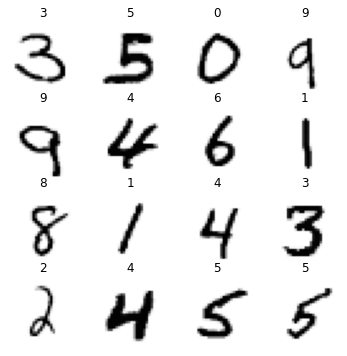

In [ ]:
#export
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                  get_y=parent_label)
dls = mnist.dataloaders(path,bs=16)
dls.show_batch(max_n=36,figsize=(6,6))

In [ ]:
dls.train.items[:10]

[Path('/root/.fastai/data/mnist_png/training/4/461.png'),
 Path('/root/.fastai/data/mnist_png/training/4/46777.png'),
 Path('/root/.fastai/data/mnist_png/training/4/45916.png'),
 Path('/root/.fastai/data/mnist_png/training/4/4386.png'),
 Path('/root/.fastai/data/mnist_png/training/4/59708.png'),
 Path('/root/.fastai/data/mnist_png/training/4/5155.png'),
 Path('/root/.fastai/data/mnist_png/training/4/49629.png'),
 Path('/root/.fastai/data/mnist_png/training/4/59614.png'),
 Path('/root/.fastai/data/mnist_png/training/4/18362.png'),
 Path('/root/.fastai/data/mnist_png/training/4/4114.png')]

In [ ]:
dls.valid.items[:10]

[Path('/root/.fastai/data/mnist_png/testing/4/1636.png'),
 Path('/root/.fastai/data/mnist_png/testing/4/3169.png'),
 Path('/root/.fastai/data/mnist_png/testing/4/9347.png'),
 Path('/root/.fastai/data/mnist_png/testing/4/7033.png'),
 Path('/root/.fastai/data/mnist_png/testing/4/3341.png'),
 Path('/root/.fastai/data/mnist_png/testing/4/6378.png'),
 Path('/root/.fastai/data/mnist_png/testing/4/3298.png'),
 Path('/root/.fastai/data/mnist_png/testing/4/7611.png'),
 Path('/root/.fastai/data/mnist_png/testing/4/6369.png'),
 Path('/root/.fastai/data/mnist_png/testing/4/3718.png')]

In [ ]:
dls.n_subsets

2

In [ ]:
dls.train_ds, dls.valid_ds

((#53942) [(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4))...],
 (#9058) [(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=

In [ ]:
#export
learn = cnn_learner(dls, resnet18, metrics=accuracy, loss_func=LabelSmoothingCrossEntropyFlat())

In [ ]:
learn.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=1.3182567499825382e-06)

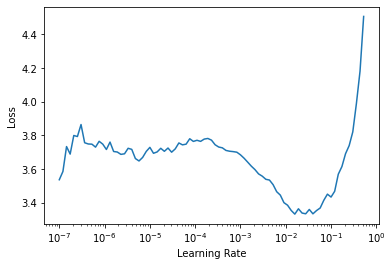

In [ ]:
learn.lr_find()

In [ ]:
#export
learn.fine_tune(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.288156,1.037335,0.811769,02:09


epoch,train_loss,valid_loss,accuracy,time
0,0.675853,0.573143,0.980790,02:25


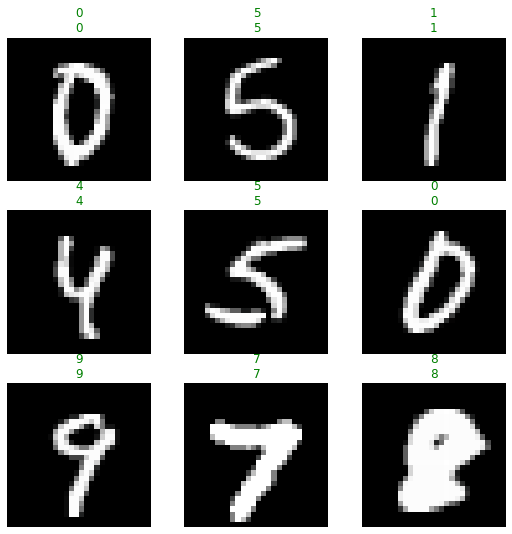

In [ ]:
learn.show_results(ds_idx=1)

In [ ]:
#export
val_preds = learn.get_preds(ds_idx=1, with_decoded=True)

In [ ]:
#hide
!pip install cleanlab -q

     |████████████████████████████████| 61kB 7.0MB/s 


In [ ]:
#export
from cleanlab.pruning import get_noise_indices

In [ ]:
#export
val_ordered_label_errors = get_noise_indices(s=val_preds[1].numpy(), psx=val_preds[0].numpy(), sorted_index_method='normalized_margin')

In [ ]:
len(val_ordered_label_errors)

6

In [ ]:
val_ordered_label_errors

array([4466, 5783, 2480, 5664, 8304, 5338])

In [ ]:
val_preds[0][0].argmax(0).item()

4

In [ ]:
for i in val_ordered_label_errors:
  #target, preds, preds_proba
  print(val_preds[1][i], val_preds[0][i].argmax().item(), val_preds[0][i].max()) #0.9 is good threshold to treat as noisy labels
  show_at(dls.valid_ds, idx=i)

Dataset Pruning ie removing the noisy labels reported is not effective as it removes the most complicated ones.